In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Hawk

[Paper](https://arxiv.org/abs/2402.19427)

Hawk is an RNN-style model using a Real-Gated Linear Recurrent Unit (RG-LRU). In the RG-LRU, inputs are sent in two linear layers with sigmoid activations (recurrence gate and input gate) to produce $r_{t}$ and $i_{t}$, then the hidden state of the RG-LRU (which is also the output at the current timestamp like in an RNN) is updated with:
$$a_{t} = a^{cr_{t}}$$
$$h_{t} = a_{t} \times h_{t-1} + \sqrt{1 - a_{t}^{2}} \times i_{t} \times x_{t}$$
where $a$ is a learned weight and $c$ an hyper-parameter. The products are all elementwise.

The code is then pretty straightforward:

In [11]:
def get_model_device(model):
    return next(iter(model.parameters())).device

In [12]:
class RGLRU(nn.Module):
    def __init__(self, hidden_size: int, c: float = 8.0):
        super().__init__()
        self.hidden_size = hidden_size
        self.c = c

        self.input_gate = nn.Linear(hidden_size, hidden_size, bias=False)
        self.recurrence_gate = nn.Linear(hidden_size, hidden_size, bias=False)
        self.a = nn.Parameter(torch.empty(hidden_size))

    def forward(self, x_t: torch.Tensor, state: torch.Tensor) -> torch.Tensor:
        batch_size, hidden_size = x_t.shape
        assert hidden_size == self.hidden_size
        assert state.shape[0] == batch_size

        i_t = torch.sigmoid(self.input_gate(x_t))
        r_t = torch.sigmoid(self.recurrence_gate(x_t))

        # Compute recurrence
        a_t = self.a ** (self.c * r_t)
        multiplier = torch.sqrt(1 - a_t**2)
        new_state = (state * a_t) + (multiplier * (i_t * x_t))

        return new_state

    def init_state(self, batch_size: int, device: torch.device | None = None):
        if device is None:
            device = get_model_device(self)
        return torch.zeros(batch_size, self.hidden_size, device=device)

You can then use it like any RNN:

In [14]:
batch_size = 4
hidden_size = 32
kernel_size = 4
x = torch.randn(batch_size, hidden_size)

rglru = RGLRU(hidden_size)
state = rglru.init_state(batch_size)
new_state = rglru(x, state)

The convolution layers in Hawk are 1d conv on the sequence dimension. To be able to apply a convolutional layer on just one event, we need to keep around some of the last events in a state to be able to form a full window. More precisely, we need `kernel_size` events to be able to apply the convolutional layer and get one output, so we keep the `kernel_size-1` last events.

This is all coded in this layer:

In [15]:
class CausalConv1d(nn.Module):
    """
    Causal convolution layer: the hidden state contains the last kernel_size - 1 events
    (zeros initially) so we can have compute the convolution on a full window when
    receiving a new event.
    """

    def __init__(self, hidden_size, kernel_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.kernel_size = kernel_size
        self.conv = nn.Conv1d(
            hidden_size, hidden_size, kernel_size, groups=hidden_size, bias=True
        )

    def init_state(self, batch_size: int, device: torch.device | None = None):
        if device is None:
            device = get_model_device(self)
        return torch.zeros(
            batch_size, self.hidden_size, self.kernel_size - 1, device=device
        )

    def forward(self, x: torch.Tensor, state: torch.Tensor):
        x_with_state = torch.concat([state, x[:, :, None]], dim=-1)
        out = self.conv(x_with_state)
        new_state = x_with_state[:, :, 1:]
        return out.squeeze(-1), new_state

Here is an example of use on random inputs:

In [16]:
batch_size = 4
hidden_size = 32
kernel_size = 4
x = torch.randn(batch_size, hidden_size)

conv = CausalConv1d(hidden_size, kernel_size)
state = conv.init_state(batch_size)
out, new_state = conv(x, state)

The Hawk module then looks like this:

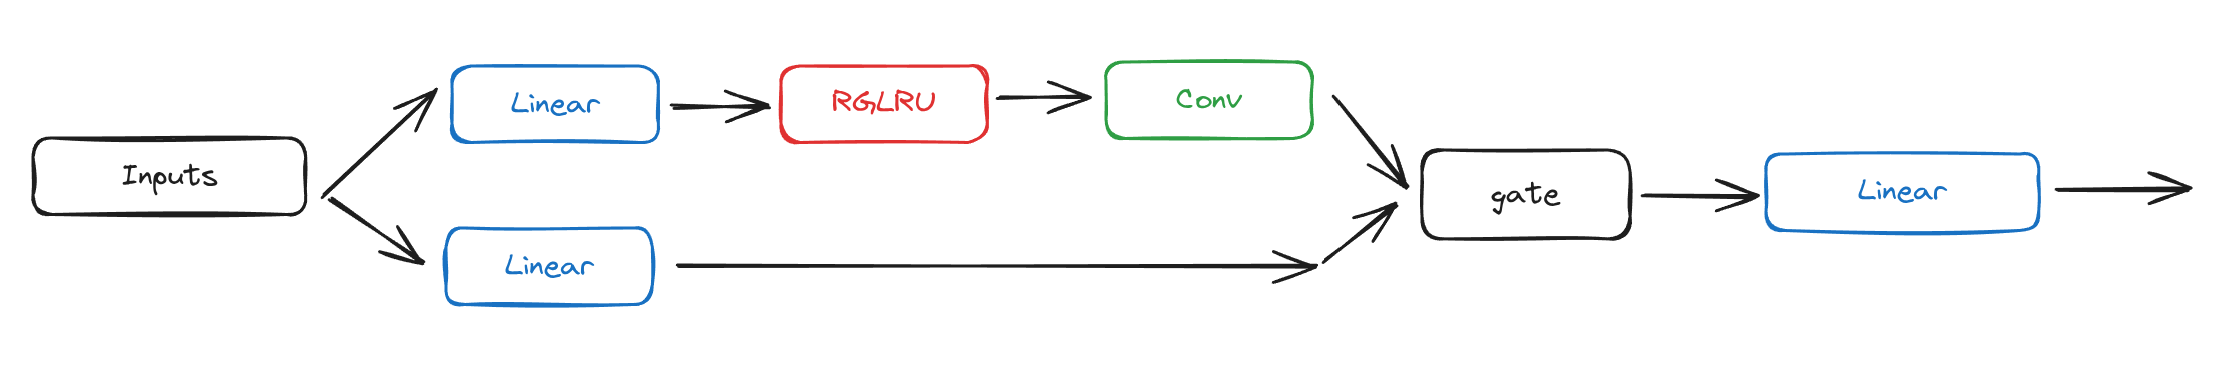

In [ ]:
class Hawk(nn.Module):
    def __init__(self, hidden_size: int, conv_kernel_size: int = 4):
        super().__init__()

        self.conv_kernel_size = conv_kernel_size
        self.hidden_size = hidden_size

        self.gate_proj = nn.Linear(hidden_size, hidden_size, bias=False)
        self.recurrent_proj = nn.Linear(hidden_size, hidden_size, bias=False)
        self.conv = CausalConv1d(hidden_size, conv_kernel_size)
        self.rglru = RGLRU(hidden_size)
        self.out_proj = nn.Linear(hidden_size, hidden_size, bias=False)

    def forward(
        self, x: torch.Tensor, state: tuple[torch.Tensor, torch.Tensor]
    ) -> tuple[torch.Tensor, list[torch.Tensor]]:
        conv_state, rglru_state = state

        batch_size, hidden_size = x.shape
        assert batch_size == conv_state.shape[0] == rglru_state.shape[0]
        assert self.hidden_size == hidden_size == rglru_state.shape[1]

        gate = F.gelu(self.gate_proj(x))
        x = self.recurrent_proj(x)

        x, new_conv_state = self.conv(x, conv_state)
        new_rglru_state = self.rglru(x, rglru_state)

        gated = gate * new_rglru_state
        out = self.out_proj(gated)

        new_state = [new_conv_state, new_rglru_state]
        return out, new_state

    def init_state(
        self, batch_size: int, device: torch.device | None = None
    ) -> list[torch.Tensor]:
        return [
            self.conv.init_state(batch_size, device),
            self.rglru.init_state(batch_size, device),
        ]